In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from scipy.optimize import newton

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path :
    sys.path.append(module_path)
import _ressources.flux as fl


from matplotlib.colors import LogNorm, SymLogNorm

# $\Delta_c$ VS $\Delta_p$

The equation for zero-hydraulic flux is given by :
$$\Delta P = -\Delta C \frac{\Lambda (\chi_s, \chi_v)}{\cosh \left( \frac{1}{2\chi_v} \right)}$$

In [3]:
def Lambda(chis, chiv) :
    c1, s1 = np.cosh(1./chis), np.sinh(1./chis)
    if chis == chiv :
        return np.cosh(0.5/chiv) * (1 - chiv*s1) / (2*chiv*s1) 
    return chis*(chis*s1*np.cosh(0.5/chiv) - chiv*(1.+c1)*np.sinh(0.5/chiv)) / (s1 * (chiv**2 - chis**2))

def zero_Jv_DelP(DelC, chis, chiv) :
    return -DelC*Lambda(chis, chiv) /np.cosh(0.5/chiv)

def Jv(DelP, DelC, chis, chiv) :
    return chiv*(DelP*np.cosh(0.5/chiv)/np.sinh(0.5/chiv) + DelC*Lambda(chis, chiv) /np.sinh(0.5/chiv))

def asymmetric_curve(Xs, Xv, dC_max = 5., nb_pts=101) :
    # RIGHT PART
    dC2_right = np.linspace(1, dC_max, nb_pts)
    dC1_right = 1
    DelC_right = dC2_right - dC1_right

    P1_right = 1

    DelP_right = zero_Jv_DelP(DelC_right, Xs, Xv)
    
    P2_right = DelP_right + P1_right
    
    Asym_dC_right = (dC2_right-dC1_right)/(dC2_right+dC1_right)
    Asym_dP_right = (P2_right-P1_right)/(P2_right+P1_right)
    
    # LEFT PART
    dC1_left = np.linspace(1, dC_max, nb_pts)
    dC2_left = 1
    DelC_left = dC2_left - dC1_left

    P2_left = 1

    DelP_left = zero_Jv_DelP(DelC_left, Xs, Xv)
    
    P1_left = P2_left - DelP_left

    Asym_dC_left = (dC2_left-dC1_left)/(dC2_left+dC1_left)
    Asym_dP_left = (P2_left-P1_left)/(P2_left+P1_left)
    
    # CONCATENATE
    Asym_dC = np.concatenate((Asym_dC_left[::-1], Asym_dC_right))
    Asym_dP = np.concatenate((Asym_dP_left[::-1], Asym_dP_right))
    return Asym_dC, Asym_dP

c_list = ['#037bfc', '#1403fc', '#2580c2', 
          '#ff4800', '#c71e1e', '#ff7c1f',
          '#00bf03', '#24bd54', '#5dba16']
lst = ['-', '-', '-', '.']

# Limits of the $\Lambda$-function 
The $\Lambda$-function is defined as
$$\Lambda(\chi_s, \chi_v) = \frac{1}{\sinh \frac{1}{\chi_s}} \frac{\chi_s}{\chi_v^2 - \chi_s^2}\left[ \chi_s s_1 \cosh \frac{1}{2\chi_v} - \chi_v (1 + c_1) \sinh \frac{1}{2\chi_v} \right]$$
where $s_1 = \sinh\left[\frac{1}{\chi_s}\right]$ and $c_1 = \cosh\left[\frac{1}{\chi_s}\right]$
In the special case where $\chi_s = \chi_v = \chi$, the function $\Lambda$ reduces to
$$\Lambda(\chi) = \frac{1 - \chi \sinh(\frac{1}{\chi}) }{2\chi \sinh(\frac{1}{\chi}) } \cosh \left( \frac{1}{2\chi} \right)$$

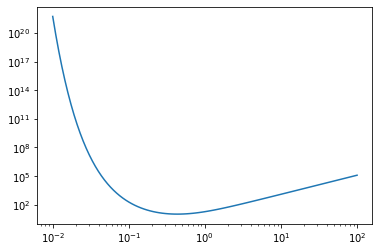

In [4]:
Xs = 2.
Xv = np.logspace(-2, 2, 101)
L = np.array([Lambda(Xs, Xv[i]) for i in range(len(Xv))])
plt.xscale('log')
plt.yscale('log')
plt.plot(Xv, -np.cosh(1/Xv)/L)

# $\Delta_c$ VS $\Delta_P$

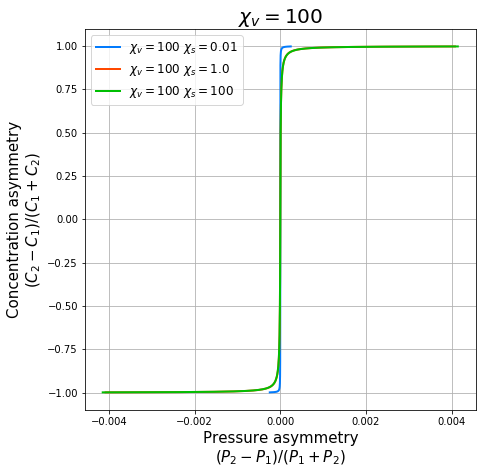

In [5]:
chis_list, chiv_list = [0.01, 1., 100], [100]
plt.figure(figsize=(7, 7))
c=0
for i in range(len(chis_list)) :
    ls = lst[i]
    for j in range(len(chiv_list)) :
        Asym_dC, Asym_dP = asymmetric_curve(Xs=chis_list[i], Xv=chiv_list[j], dC_max=1000., nb_pts=1001)
        plt.plot(np.copy(Asym_dP), np.copy(Asym_dC), label = r'$\chi_v=$' +str(chiv_list[j]) + r' $\chi_s=$'+str(chis_list[i]), linewidth=2, color=c_list[c], linestyle=ls)
        c+=3
        
plt.legend(loc='upper left', fontsize=12)
plt.grid()
plt.ylabel('Concentration asymmetry\n'+r'$(C_2 - C_1) / (C_1 + C_2)$', fontsize=15)
plt.xlabel('Pressure asymmetry\n'+r'$(P_2 - P_1) / (P_1 + P_2)$', fontsize=15)
#plt.title('$\chi_s = '+str(chis_list[0])+'$', fontsize=20)
plt.title(r'$\chi_v = $'+str(chiv_list[0]), fontsize=20)
#plt.savefig('/Users/mathieuleverge/git/chain_lumen/_notebook/figures/zero_flux_hydraulic_analyticsolution.eps', format='eps', dpi=100)
plt.show()



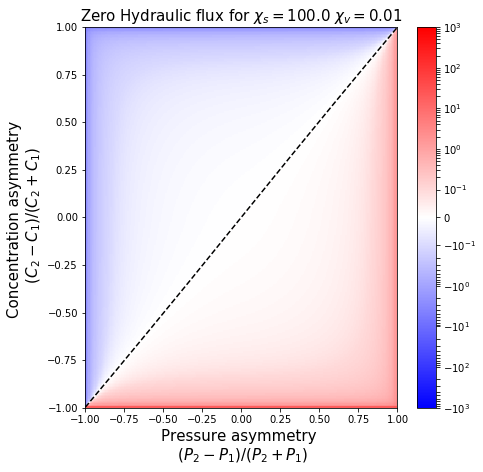

In [6]:
chis = 100.
chiv = .01

npts_p, npts_c = 256, 256
dpmin, dpmax = -0.999, 0.999
dcmin, dcmax = -0.999, 0.999
DP_list = np.linspace(dpmin, dpmax, npts_p)
#DP_list = np.array(list(-1.*1e-2 / np.logspace(-2, 0, npts_p//2)[::-1])+[0.]+list(1e-2/np.logspace(-2, 0, npts_p//2))) 
DC_list = np.linspace(dcmin, dcmax, npts_c)
#DC_list = np.array(list(-1*1e-2/np.logspace(-2, 0, npts_c//2)[::-1])+[0.]+list(1e-2/np.logspace(-2, 0, npts_p//2))) 

dp_mesh, dc_mesh = np.meshgrid(DC_list, DP_list)

jv_tot = np.zeros((npts_p, npts_c))

for i in range(npts_p) :
    for j in range(npts_c) :
        dc = dc_mesh[i, j]
        dp = dp_mesh[i, j]
        
        if dp > 0. :
            P1 = 1.
            P2 = P1*(1.+dp)/(1.-dp)
        else :
            P2 = 1.
            P1 = P2*(1.-dp)/(1.+dp)
            
        if dc > 0. :
            C1 = 1.
            C2 = C1*(1.+dc)/(1.-dc)
        else :
            C2 = 1.
            C1 = C2*(1.-dc)/(1.+dc)
            
        jv_tot[i, j] = Jv(DelP=P2-P1, DelC=C2-C1, chis=chis, chiv=chiv)
        
# Curve
Asym_dC, Asym_dP = asymmetric_curve(Xs=chis, Xv=chiv, dC_max=1000., nb_pts=1001)    
    
fig, ax = plt.subplots(figsize=(7, 7))
pcm = ax.pcolormesh(dp_mesh, dc_mesh, jv_tot,
                       norm=SymLogNorm(linthresh=1e-1, linscale=1, vmin=-1e3, vmax=1e3),
                    cmap='bwr', rasterized=False)

ax.plot(np.copy(Asym_dP), np.copy(Asym_dC), label = r'$\chi_v=$' +str(1.), color='k', linestyle='--')

ax.set_title(r'Zero Hydraulic flux for $\chi_s = $'+str(chis)+r' $\chi_v = $'+str(chiv), fontsize=15)
fig.colorbar(pcm, ax=ax)
ax.set_ylabel('Concentration asymmetry \n '+r'$(C_2-C_1)/(C_2+C_1)$', fontsize=15)
ax.set_xlabel('Pressure asymmetry \n '+r'$(P_2-P_1)/(P_2+P_1)$', fontsize=15)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
#plt.grid()
#plt.savefig('/Users/mathieuleverge/git/chain_lumen/_notebook/figures/zero_flux_hydraulic_dP_vs_dC.eps', format='eps')
plt.show()

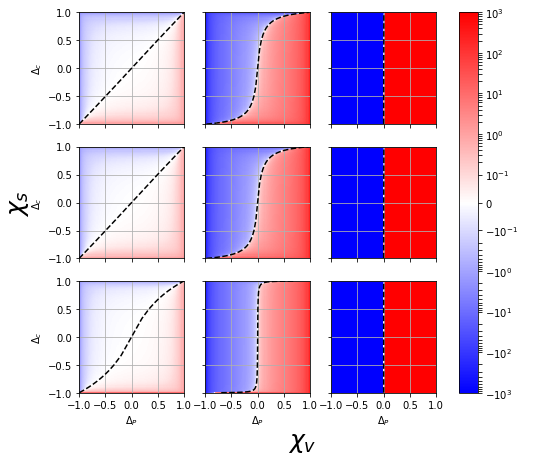

In [7]:


chis_list = [100, 1., .01]
chiv_list = [0.01, 1., 100]

fig, ax = plt.subplots(len(chiv_list), len(chis_list), figsize=(8, 7), sharex=True, sharey=True, )

plt.locator_params(nbins=5)

npts_p, npts_c = 101, 101

dpmin, dpmax = -0.999, 0.999
dcmin, dcmax = -0.999, 0.999
DP_list = np.linspace(dpmin, dpmax, npts_p)
#DP_list = np.array(list(-1.*1e-2 / np.logspace(-2, 0, npts_p//2)[::-1])+[0.]+list(1e-2/np.logspace(-2, 0, npts_p//2))) 
DC_list = np.linspace(dcmin, dcmax, npts_c)
#DC_list = np.array(list(-1*1e-2/np.logspace(-2, 0, npts_c//2)[::-1])+[0.]+list(1e-2/np.logspace(-2, 0, npts_p//2))) 

dp_mesh, dc_mesh = np.meshgrid(DC_list, DP_list)

jv_dict = {}
for n in range(len(chis_list)) :
    for m in range(len(chiv_list)) :
        chis = chis_list[n]
        chiv = chiv_list[m]
        
        jv_tot = np.zeros((npts_p, npts_c))
        for i in range(npts_p) :
            for j in range(npts_c) :
                dc = dc_mesh[i, j]
                dp = dp_mesh[i, j]

                if dp > 0. :
                    P1 = 1.
                    P2 = P1*(1.+dp)/(1.-dp)
                else :
                    P2 = 1.
                    P1 = P2*(1.-dp)/(1.+dp)

                if dc > 0. :
                    C1 = 1.
                    C2 = C1*(1.+dc)/(1.-dc)
                else :
                    C2 = 1.
                    C1 = C2*(1.-dc)/(1.+dc)

                jv_tot[i, j] = Jv(DelP=P2-P1, DelC=C2-C1, chis=chis, chiv=chiv)
                # Curve
        Asym_dC, Asym_dP = asymmetric_curve(Xs=chis, Xv=chiv, dC_max=1000., nb_pts=1001)
        jv_dict[(i,j)] = jv_tot
        
        pcm = ax[n,m].pcolormesh(dp_mesh, dc_mesh, jv_tot, norm=SymLogNorm(linthresh=1e-1, linscale=1, vmin=-1e3, vmax=1e3), cmap='bwr', rasterized=False)
        ax[n,m].plot(np.copy(Asym_dP), np.copy(Asym_dC), color='k', linestyle='--')
        ax[n,m].set_xlim(-1, 1)
        ax[n,m].set_ylim(-1, 1)
        ax[n,m].grid()
        if n==2 :
            ax[n,m].set_xlabel(r'$\Delta_P$')
        if m==0 :
            ax[n,m].set_ylabel(r'$\Delta_c$')
        #ax[n,m].set_title('chiv='+str(chiv)+' chis='+str(chis))
        

#plt.suptitle(r'Zero Hydraulic flux', fontsize=25)
fig.colorbar(pcm, ax=ax)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
#plt.spines['right'].set_color('none')
#plt.spines['top'].set_color('none')
#plt.ylabel('Concentration asymmetry \n '+r'$(C_2-C_1)/(C_2+C_1)$', fontsize=15)
#plt.xlabel('Pressure asymmetry \n '+r'$(P_2-P_1)/(P_2+P_1)$', fontsize=15)

plt.xlabel(r'$\chi_v$', fontsize=25, labelpad=20)
plt.ylabel(r'$\chi_s$', fontsize=25, labelpad=25)

#plt.grid()
plt.savefig('/Users/mathieuleverge/git/chain_lumen/_notebook/figures/zero_flux_hydraulic_dP_vs_dC_colored_9cases.eps', format='eps')
plt.show()

# $\Delta_c$ VS $\chi_v$

In [8]:
def give_lab(jv):
    if jv > 0:
        return '2 => 1'
    return '1 => 2'

In [9]:
def calc_deltaC(chiv_list, P1, P2, C1, chis) :
    
    DP = P2-P1
    Pbar = P1+P2
    print(DP/Pbar)

    delC = -np.array([DP*np.cosh(.5/chiv_list[i])/Lambda(chis, chiv_list[i]) for i in range(len(chiv_list))])
    C2 = C1 + delC
    delta_C = (C2-C1)/(C2+C1)
    return delta_C

0.25


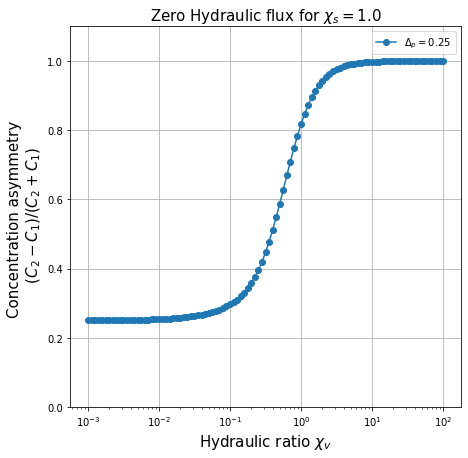

In [10]:
additionnal_curves = False
points = False

plt.figure(figsize=(7,7))
plt.xscale('log')
#plt.yscale('log')
chis = 1.
chiv_list = np.logspace(-3., 2, 101)

# First curve
C1, P1, P2 = 1., 1., 5./3.
delta_C = calc_deltaC(chiv_list, P1, P2, C1, chis)
plt.plot(chiv_list, delta_C, label = r'$\Delta_p = $'+"{:2.2f}".format((P2-P1)/(P1+P2)), marker='o')

if points : 
    chiv = 1.
    
    # point 1
    C2 = 50
    y1 = (C2-C1)/(C2+C1)
    jv1 = Jv(DelP=P2-P1, DelC=C2-C1, chis=1, chiv=chiv)
    plt.scatter(chiv, y1, label=give_lab(jv1)+ r'; $\Delta_p = $' + str((P2-P1)/(P2+P1)), color='b', marker='s')

    # point 2
    C2 = 15
    y2 = (C2-C1)/(C2+C1)
    jv2 = Jv(DelP=P2-P1, DelC=C2-C1, chis=1, chiv=chiv)
    plt.scatter(chiv, y2, label=give_lab(jv2)+ r'; $\Delta_p = $' + str((P2-P1)/(P2+P1)), color='r', marker='o')


if additionnal_curves :

    # Second curve
    C1, P1, P2 = 1., 1., 3
    delta_C = calc_deltaC(chiv_list, P1, P2, C1, chis)
    plt.plot(chiv_list, delta_C, label = r'$\Delta_p = $'+"{:2.2f}".format((P2-P1)/(P1+P2)), linestyle='--')

    # Third curve
    C1, P1, P2 = 1., 1., 1.1
    delta_C = calc_deltaC(chiv_list, P1, P2, C1, chis)
    plt.plot(chiv_list, delta_C, label = r'$\Delta_p = $'+"{:2.2f}".format((P2-P1)/(P1+P2)), linestyle='--')

    # Fourth curve
    C1, P1, P2 = 1., 1., 10
    delta_C = calc_deltaC(chiv_list, P1, P2, C1, chis)
    plt.plot(chiv_list, delta_C, label = r'$\Delta_p = $'+"{:2.2f}".format((P2-P1)/(P1+P2)), linestyle='--')
        
plt.ylabel('Concentration asymmetry \n '+r'$(C_2-C_1)/(C_2+C_1)$', fontsize=15)
plt.xlabel(r'Hydraulic ratio $\chi_v$', fontsize=15)
plt.grid()
plt.legend()
plt.ylim(0., 1.1)
#plt.axis('equal')

plt.title(r'Zero Hydraulic flux for $\chi_s = $'+str(chis), fontsize=15)
#plt.savefig('/Users/mathieuleverge/git/chain_lumen/_notebook/figures/zero_flux_hydraulic_dC_vs_chiv.eps', format='eps', dpi=100)
plt.show()


0.25


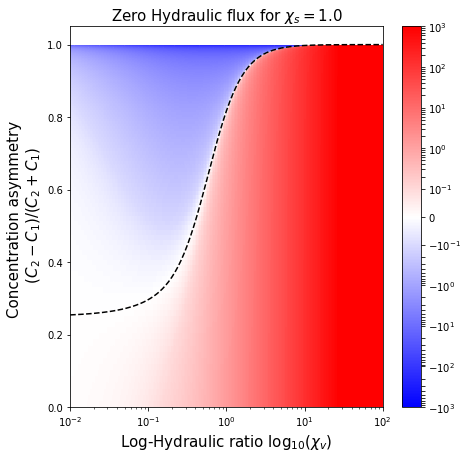

In [11]:


C1 = 1.
P1, P2 = 1., 5./3.

npts_c = 201
npts_chi = 201

chiv_list = np.logspace(-2, 2, npts_chi)
#C2_list = np.linspace(0., 1000, npts_c)
C2_list = np.logspace(0, 3, npts_c)
C2_mesh, chi_mesh = np.meshgrid(C2_list, chiv_list)

Delta_C_mesh = (C2_mesh - C1) / (C2_mesh + C1)

jv_array = np.zeros((npts_chi, npts_c))
for i in range(npts_chi) :
    for j in range(npts_c) :
        jv_array[i, j] = Jv(DelP=P2-P1, DelC=C2_mesh[i, j]-C1, chis=1, chiv=chi_mesh[i, j])

delta_C = calc_deltaC(chiv_list, P1, P2, C1, chis)        
        
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_title(r'Zero Hydraulic flux for $\chi_s = $'+str(chis), fontsize=15)

pcm = ax.pcolormesh(chi_mesh, Delta_C_mesh, jv_array,
                       norm=SymLogNorm(linthresh=1e-1, linscale=1, vmin=-1e3, vmax=1e3),
                    cmap='bwr', rasterized=False)

ax.set_xscale('log')

# First curve
plt.plot(chiv_list, delta_C, label = r'$\Delta_p = $'+"{:2.2f}".format((P2-P1)/(P1+P2)), color='k', linestyle='--')

fig.colorbar(pcm, ax=ax)

ax.set_ylabel('Concentration asymmetry \n '+r'$(C_2-C_1)/(C_2+C_1)$', fontsize=15)
ax.set_xlabel(r'Log-Hydraulic ratio $\log_{10}(\chi_v)$', fontsize=15)
#ax.grid()
#plt.savefig('/Users/mathieuleverge/git/chain_lumen/_notebook/figures/zero_flux_hydraulic_dC_vs_chiv.eps', format='eps', dpi=100)
plt.show()




In [12]:
def calc_deltaP(chiv_list, C1, C2, P1, chis) :
    DC = C2-C1
    Cbar = C1+C2
    print(DC/Cbar)

    delC = -np.array([DC*Lambda(chis, chiv_list[i])/np.cosh(.5/chiv_list[i]) for i in range(len(chiv_list))])
    P2 = P1 + delC
    delta_P = (P2-P1)/(P2+P1)
    return delta_P


In [13]:
delta_P = calc_deltaC(chiv_list, C1, C2, P1, chis)


0.999


0.0


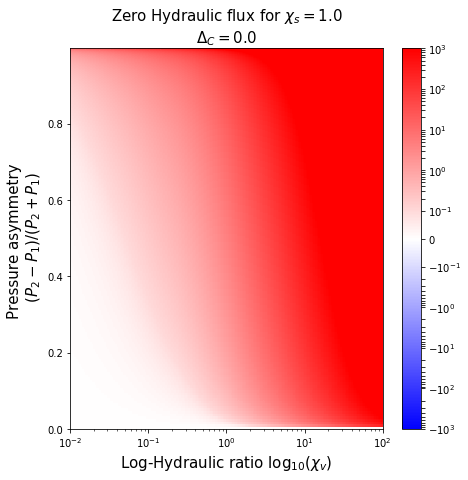

In [15]:
chis=1.

C1, C2 = 1., 1.
P1 = 1.

npts_p = 501
npts_chi = 201

chiv_list = np.logspace(-2, 2, npts_chi)
#C2_list = np.linspace(0., 1000, npts_c)
P2_list = np.logspace(0, 3, npts_p)
P2_mesh, chi_mesh = np.meshgrid(P2_list, chiv_list)

Delta_P_mesh = (P2_mesh - P1) / (P2_mesh + P1)

jv_array = np.zeros((npts_chi, npts_p))
for i in range(npts_chi) :
    for j in range(npts_p) :
        jv_array[i, j] = Jv(DelP=P2_mesh[i, j]-P1, DelC=C2-C1, chis=1, chiv=chi_mesh[i, j])

delta_P = calc_deltaP(chiv_list, C1, C2, P1, chis)        
        
fig, ax = plt.subplots(figsize=(7, 7))

ax.set_title(r'Zero Hydraulic flux for $\chi_s = $'+str(chis)+'\n'+r'$\Delta_C = $'+str((C2-C1)/(C1+C2)), fontsize=15)

pcm = ax.pcolormesh(chi_mesh, Delta_P_mesh, jv_array,
                       norm=SymLogNorm(linthresh=1e-1, linscale=1, vmin=-1e3, vmax=1e3),
                    cmap='bwr', rasterized=False)

ax.set_xscale('log')

# First curve
#plt.plot(chiv_list, delta_P, label = r'$\Delta_p = $'+"{:2.2f}".format((P2-P1)/(P1+P2)), color='k', linestyle='--')

fig.colorbar(pcm, ax=ax)

ax.set_ylabel('Pressure asymmetry \n '+r'$(P_2-P_1)/(P_2+P_1)$', fontsize=15)
ax.set_xlabel(r'Log-Hydraulic ratio $\log_{10}(\chi_v)$', fontsize=15)
#ax.grid()
#plt.savefig('/Users/mathieuleverge/git/chain_lumen/_notebook/figures/zero_flux_hydraulic_dP_vs_chiv.eps', format='eps', dpi=100)
plt.show()


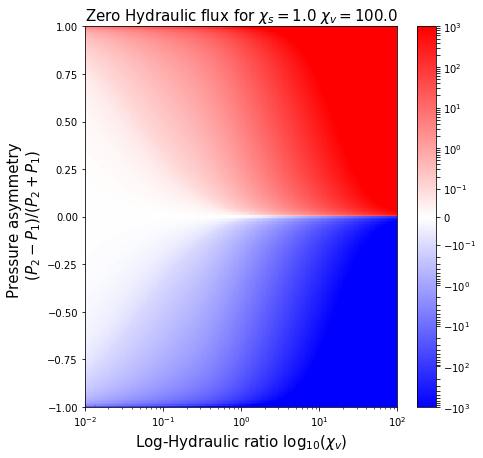

In [23]:
chis = 1.

C2, C1 = 1., 1.

npts_p, npts_chi = 256, 256
dpmin, dpmax = -0.999, 0.999
chimin, chimax = -2, 2
DP_list = np.linspace(dpmin, dpmax, npts_p)
#DP_list = np.array(list(-1.*1e-2 / np.logspace(-2, 0, npts_p//2)[::-1])+[0.]+list(1e-2/np.logspace(-2, 0, npts_p//2))) 
chi_list = np.logspace(chimin, chimax, npts_chi)
#DC_list = np.array(list(-1*1e-2/np.logspace(-2, 0, npts_c//2)[::-1])+[0.]+list(1e-2/np.logspace(-2, 0, npts_p//2))) 

dp_mesh, chi_mesh = np.meshgrid(DP_list, chi_list)

jv_tot = np.zeros((npts_p, npts_chi))

for i in range(npts_chi) :
    for j in range(npts_p) :
        chiv = chi_mesh[i, j]
        dp = dp_mesh[i, j]
        
        if dp > 0. :
            P1 = 1.
            P2 = P1*(1.+dp)/(1.-dp)
        else :
            P2 = 1.
            P1 = P2*(1.-dp)/(1.+dp)
        
        jv_tot[i, j] = Jv(DelP=P2-P1, DelC=C2-C1, chis=chis, chiv=chiv)
        
# Curve
Asym_dC, Asym_dP = asymmetric_curve(Xs=chis, Xv=chiv, dC_max=1000., nb_pts=1001)    
    
fig, ax = plt.subplots(figsize=(7, 7))
pcm = ax.pcolormesh(chi_mesh, dp_mesh, jv_tot,
                       norm=SymLogNorm(linthresh=1e-1, linscale=1, vmin=-1e3, vmax=1e3),
                    cmap='bwr', rasterized=False)

#ax.plot(np.copy(Asym_dP), np.copy(Asym_dC), label = r'$\chi_v=$' +str(1.), color='k', linestyle='--')

ax.set_title(r'Zero Hydraulic flux for $\chi_s = $'+str(chis)+r' $\chi_v = $'+str(chiv), fontsize=15)
fig.colorbar(pcm, ax=ax)
ax.set_xscale('log')
ax.set_xlabel(r'Log-Hydraulic ratio $\log_{10}(\chi_v)$', fontsize=15)
ax.set_ylabel('Pressure asymmetry \n '+r'$(P_2-P_1)/(P_2+P_1)$', fontsize=15)
ax.set_xlim(1e-2, 100)
ax.set_ylim(-1, 1)
#plt.grid()
plt.savefig('/Users/mathieuleverge/git/chain_lumen/_notebook/figures/net_flux_hydraulic_dP_vs_dC.eps', format='eps')
plt.show()